# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier



---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. 


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
### import
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
import pickle
%matplotlib inline

In [2]:
# Load pickled data

# TODO: fill this in based on where you saved the training and testing data
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


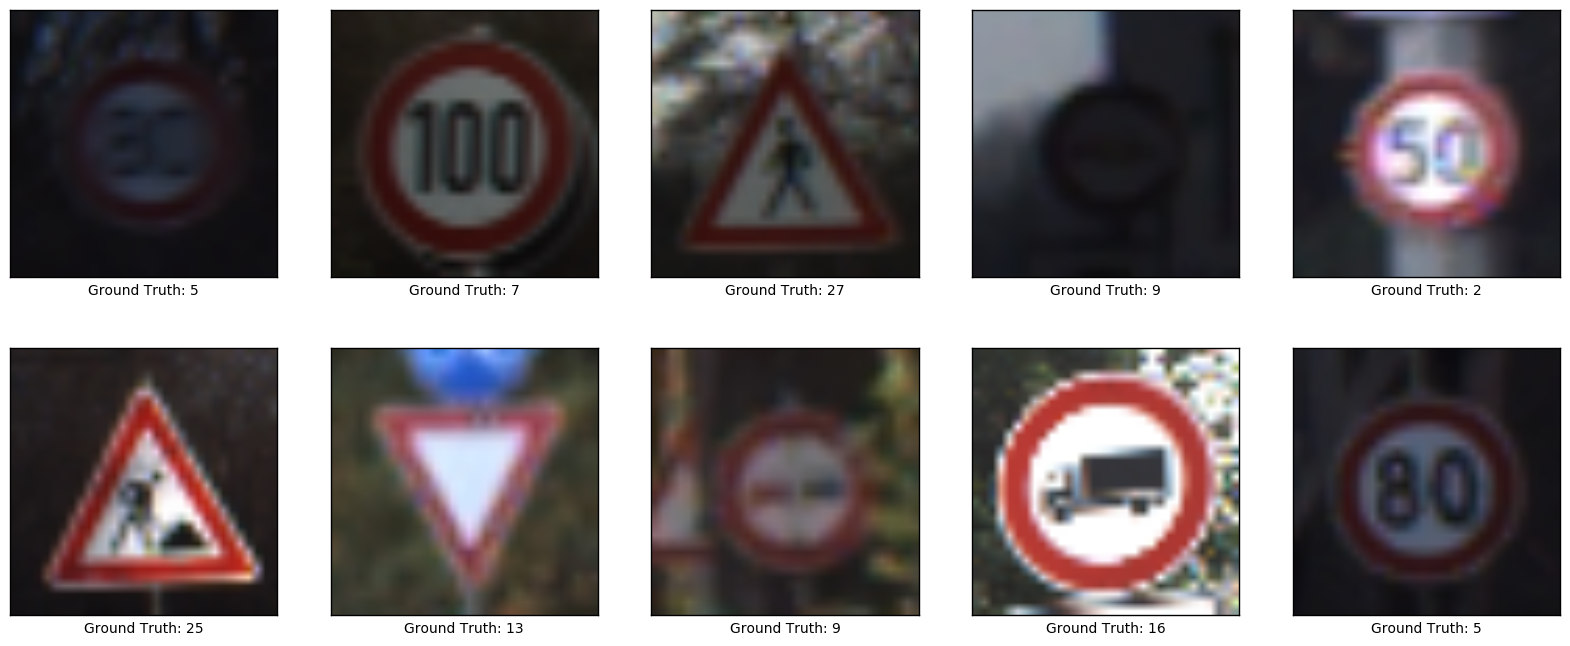

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
fig = plt.figure(figsize=(20, 8))

image_seq = np.random.randint(1,len(X_train),10)

for ind,val in enumerate(image_seq):
    img = fig.add_subplot(2,5,ind+1)
    plt.imshow(X_train[val-1])
    #Add corresponding label
    img.set_xlabel("Ground Truth: {0}".format(y_train[val-1]))
    #Remove the axis ticks
    img.set_xticks([])
    img.set_yticks([])

plt.show()

----

## Step 2: Design and Test a Model Architecture


### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# Grayscale conversion
'''
Weighted average approach utilizing numpy functions. No need for OpenCV
Y' = 0.299 R + 0.587 G + 0.114 B 
'''
X_train_gray = np.dot(X_train[...][...,:3],[0.299,0.587,0.114])
X_test_gray = np.dot(X_test[...][...,:3],[0.299,0.587,0.114])


# Normalize data (Zero-Mean)
X_train_gray_norm = (X_train_gray - np.mean(X_train_gray))/np.std(X_train_gray)
X_test_gray_norm = (X_test_gray - np.mean(X_test_gray))/np.std(X_test_gray)

In [6]:
# One-Hot Encoding
'''
Since we already have the labels we can use Label Binarizer.
'''

encoder = preprocessing.LabelBinarizer()
y_train_oh = encoder.fit_transform(y_train)
y_test_oh = encoder.fit_transform(y_test)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [7]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

'''
Use sklearn to split training data into training and validation set. Keep test data for test set.
'''
train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train_gray_norm, y_train_oh, test_size=0.15, random_state=422016)

train_features, train_labels = shuffle(train_features, train_labels)
valid_features, valid_labels = shuffle(valid_features, valid_labels)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Define Parameters
learning_rate = 0.001
training_epochs = 30
batch_size = 100
display_step = 1

n_input = len(train_features[0])**2
# n_classes already defined = 43

n_hidden_layer = 256 # width of the layer

# Weights and biases

weights = {
    'hidden_layer_1': tf.Variable(tf.truncated_normal([n_input, n_hidden_layer], mean = 0.0, stddev = 0.01)),
    'hidden_layer_2': tf.Variable(tf.truncated_normal([n_hidden_layer, n_hidden_layer], mean = 0.0, stddev = 0.01)),
    'out': tf.Variable(tf.truncated_normal([n_hidden_layer, n_classes], mean = 0.0, stddev = 0.01))
}

biases = {
    'hidden_layer_1': tf.Variable(tf.truncated_normal([n_hidden_layer])),
    'hidden_layer_2': tf.Variable(tf.truncated_normal([n_hidden_layer])),
    'out': tf.Variable(tf.truncated_normal([n_classes]))
}

In [9]:
# Flatten/Reshape data
X_test_gray_flat = np.reshape(X_test_gray_norm, [-1, n_input])
train_features_flat = np.reshape(train_features, [-1, n_input])
valid_features_flat = np.reshape(valid_features, [-1, n_input])

# Input graph for TF
network_input = tf.placeholder("float", [None, n_input])
network_output = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

# Hidden layer 1 with ReLU activation
hidden_layer_1 = tf.add(tf.matmul(network_input, weights['hidden_layer_1']), biases['hidden_layer_1'])
hidden_layer_1 = tf.nn.relu(hidden_layer_1)
hidden_layer_1 = tf.nn.dropout(hidden_layer_1, keep_prob)


# Hidden layer 2 with ReLU activation
hidden_layer_2 = tf.add(tf.matmul(hidden_layer_1, weights['hidden_layer_2']), biases['hidden_layer_2'])
hidden_layer_2 = tf.nn.relu(hidden_layer_2)
hidden_layer_2 = tf.nn.dropout(hidden_layer_2, keep_prob)

logits = tf.add(tf.matmul(hidden_layer_2, weights['out']), biases['out'])

# Check if predictions are correct.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(network_output, 1))
# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# Cost function and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, network_output))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


In [10]:
# Initialize variables
init = tf.global_variables_initializer()

# Launch graph
with tf.Session() as session:
    session.run(init)
    
    # Training cycle
    for epochs in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(train_features)/batch_size)
        
        for i in range(total_batch):
            idx_l = i*batch_size
            idx_h = idx_l + batch_size
            
            batch_x = train_features_flat[idx_l:idx_h]
            batch_y = train_labels[idx_l:idx_h]
                        
            _,c = session.run([optimizer, cost], feed_dict = {network_input: batch_x, network_output: batch_y, keep_prob: 0.5})
            
            # Compute average loss
            avg_cost += c / total_batch
            
        # Display logs per epoch step
        if epochs % display_step == 0:
            print("Epoch:", '%04d' % (epochs+1), "cost=", \
                "{:.9f}".format(avg_cost))
            
    print("Optimization Finished!")
    
    # Calculate accuracy
    training_accuracy = session.run(accuracy, feed_dict = 
                                            {network_input: train_features_flat, network_output: train_labels, keep_prob: 0.5})
            
    validation_accuracy = session.run(accuracy, feed_dict = 
                                            {network_input: valid_features_flat, network_output: valid_labels, keep_prob: 1.0})
    
    test_accuracy = session.run(accuracy, feed_dict = 
                                            {network_input: X_test_gray_flat, network_output: y_test_oh, keep_prob: 1.0})
    print("Training Accuracy:", training_accuracy)
    print("Validation Accuracy:", validation_accuracy)
    print("Test Accuracy:", test_accuracy)
    

Epoch: 0001 cost= 2.485552721
Epoch: 0002 cost= 1.355790310
Epoch: 0003 cost= 1.036331240
Epoch: 0004 cost= 0.870250821
Epoch: 0005 cost= 0.792140239
Epoch: 0006 cost= 0.735074854
Epoch: 0007 cost= 0.682681533
Epoch: 0008 cost= 0.649850062
Epoch: 0009 cost= 0.617886684
Epoch: 0010 cost= 0.593484248
Epoch: 0011 cost= 0.580373802
Epoch: 0012 cost= 0.564310446
Epoch: 0013 cost= 0.555810101
Epoch: 0014 cost= 0.535826707
Epoch: 0015 cost= 0.517023820
Epoch: 0016 cost= 0.512912041
Epoch: 0017 cost= 0.512891394
Epoch: 0018 cost= 0.495614589
Epoch: 0019 cost= 0.489160529
Epoch: 0020 cost= 0.482674076
Epoch: 0021 cost= 0.462338787
Epoch: 0022 cost= 0.462868628
Epoch: 0023 cost= 0.464436918
Epoch: 0024 cost= 0.462643628
Epoch: 0025 cost= 0.450184550
Epoch: 0026 cost= 0.445113221
Epoch: 0027 cost= 0.434607879
Epoch: 0028 cost= 0.453332403
Epoch: 0029 cost= 0.436519512
Epoch: 0030 cost= 0.427816842
Optimization Finished!
Training Accuracy: 0.861734
Validation Accuracy: 0.923665
Test Accuracy: 0.85

In [ ]:
## The following code can be useful for when to have plots on loss (cost) or accuracy (training and validation).
## But this is very slow. Might have to make changes to some variables for this to work.
'''
from tqdm import tqdm

batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []
display_step = 50

# Initialize variables
init = tf.global_variables_initializer()

# Launch graph
with tf.Session() as session:
    session.run(init)
    
    # Training cycle
    for epochs in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(train_features)/batch_size)
        
        # Progress bar
        batches_pbar = tqdm(range(total_batch), desc='Epoch {:>2}/{}'.format(epochs, training_epochs), unit='batches')
        
        for i in range(total_batch):
            idx_l = i*batch_size
            idx_h = idx_l + batch_size
            
            batch_x = train_features[idx_l:idx_h]
            batch_y = train_labels[idx_l:idx_h]
            
            batch_x_flat = np.reshape(batch_x, [-1, n_input])
                        
            _,c = session.run([optimizer, cost], feed_dict = {network_input: batch_x_flat, network_output: batch_y})
            

            if not i % display_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict = {network_input: train_features_flat, 
                                                                       network_output: train_labels})
                validation_accuracy = session.run(accuracy, feed_dict = {network_input: valid_features_flat, 
                                                                         network_output: valid_labels})

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(display_step + previous_batch)
                loss_batch.append(c)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)
        
        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict = {network_input: valid_features_flat, network_output: valid_labels})
            
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))
'''